https://arxiv.org/pdf/1704.04110.pdf

https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_electricity/DeepAR-Electricity.ipynb


In [1]:
import pandas as pd

d = pd.read_csv('LD2011_2014.txt', sep=';', thousands=',', index_col=0, )
d.index = pd.to_datetime(d.index)
d.shape

(140256, 370)

In [2]:
d.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [3]:
d = d.resample('H', how='sum')
d.head()

/home/dante/venvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [4]:
d.shape

(35065, 370)

In [5]:
# hopw many training examples total
import numpy as np
sum(d.apply(lambda s: np.argwhere(s > 0).reshape(-1).max() - np.argwhere(s > 0).reshape(-1).min()))

/home/dante/venvs/python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


10463878

In [6]:
# all observations are 1 hour intervals
pd.Series(d.index).diff().unique()

array([        'NaT', 3600000000000], dtype='timedelta64[ns]')

In [7]:
for c in d.columns:
    d[c] = d[c].astype(float)
d.dtypes

MT_001    float64
MT_002    float64
MT_003    float64
MT_004    float64
MT_005    float64
           ...   
MT_366    float64
MT_367    float64
MT_368    float64
MT_369    float64
MT_370    float64
Length: 370, dtype: object

In [8]:
d.index.min(), d.index.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2015-01-01 00:00:00'))

In [9]:
d.shape

(35065, 370)

In [10]:
d.sum(axis=0)

MT_001    1.899547e+19
MT_002    2.755961e+19
MT_003    2.490666e+19
MT_004    5.058810e+19
MT_005    4.527706e+19
              ...     
MT_366    4.462558e+19
MT_367    5.406011e+19
MT_368    3.381737e+19
MT_369    6.853980e+19
MT_370    1.331800e+19
Length: 370, dtype: float64

In [11]:
d.isnull().any().any()

False

In [12]:
d_train = d[:'2014-09-01']
d_test = d['2014-09-01':]

# feature engineering

In [13]:
import numpy as np


# 7 days of context to predict one day of outcomes
condition_length = 24 * 7
prediction_length = 24


def featurize(s, id):
    name = s.name
    s = drop_padded_values(s)
    df = convert_series_to_frame(s)
    try:
        df = add_categorical_features(df, id)
    except:
        print(id)
    df = add_scaling_factor(df)
    df['name'] = name
    return df

def drop_padded_values(s):
    return np.trim_zeros(s)

def convert_series_to_frame(s):
    return s.to_frame().rename({s.name: 'z'}, axis=1)

def add_categorical_features(df, id):
    df['id'] = id
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['week_of_year'] = df.index.weekofyear
    df['age'] = np.arange(len(df))
    return df


# https://stackoverflow.com/questions/6811183/rolling-window-for-1d-arrays-in-numpy/6811241#6811241
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def add_scaling_factor(df):
    z = df.z.values
    df['scale_factor'] = 0
    df['scale_factor'].iloc[condition_length-1:] = 1 + np.mean(rolling_window(z, condition_length), axis=1)
    return df
    
%time df = pd.concat(featurize(d_train.iloc[:, i], i) for i in range(d_train.shape[-1]) if not i == 222)

/home/dante/venvs/python36/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


CPU times: user 5.27 s, sys: 256 ms, total: 5.53 s
Wall time: 5.53 s


In [14]:
rolling_window(np.arange(6), 3).mean(axis=1)

array([1., 2., 3., 4.])

In [15]:
assert df.scale_factor.lt(0).sum() == 0, df.scale_factor.lt(0).sum()

In [16]:
df.scale_factor.hist()

In [17]:
df.scale_factor.min(), df.scale_factor.max(), df.scale_factor.mean()

(0.0, 3629400231708403.5, 1348253872169694.5)

In [18]:
max_values = df.groupby('name').age.max().to_dict()
df['scale_factor'] = np.where(df.name.map(max_values) - df.age < prediction_length + 1, 0, df.scale_factor)

In [19]:
df.scale_factor.min(), df.scale_factor.max(), df.scale_factor.mean()

(0.0, 3629400231708403.5, 1346927224883377.0)

In [20]:
df['sample_weight'] = df.scale_factor / df.scale_factor.sum()

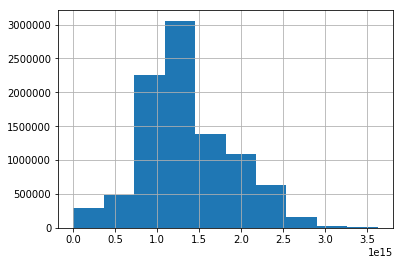

In [21]:
df.scale_factor.hist()

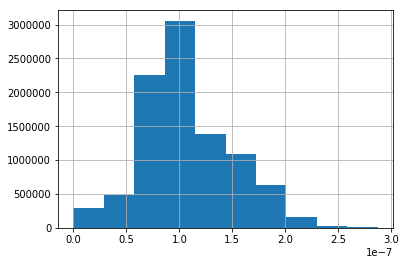

In [22]:
df.sample_weight.hist()

In [23]:
df.head()

,z,id,day_of_week,hour,month,week_of_year,age,scale_factor,name,sample_weight
2012-01-01 00:00:00,8.121827e+14,0,6,0,1,52,0,0.0,MT_001,0.0
2012-01-01 01:00:00,1.192893e+15,0,6,1,1,52,1,0.0,MT_001,0.0
2012-01-01 02:00:00,1.446701e+15,0,6,2,1,52,2,0.0,MT_001,0.0
2012-01-01 03:00:00,8.629442e+14,0,6,3,1,52,3,0.0,MT_001,0.0
2012-01-01 04:00:00,5.329949e+14,0,6,4,1,52,4,0.0,MT_001,0.0


In [24]:
# (d.iloc[:, 14]).rolling(condition_length).sum().min()

In [25]:
assert (df.scale_factor.eq(0) & df.sample_weight.gt(0)).sum() == 0

# create batch generator

In [26]:
np.random.choice(df.shape[0], p=df.sample_weight)

5889122

In [27]:
df[:condition_length].id.values.reshape((1, -1))

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [28]:
categorical_features = [
    'day_of_week', 'hour', 'month', 'week_of_year', 'age',
]

def format_example(df):
    ids = df.id.values.reshape((1, -1))
    z = df.z.values.reshape((1, -1, 1))
    x = df[categorical_features].values[np.newaxis, :, :]
    scale_factor = df.scale_factor.iloc[condition_length-1]
    validate_scale_factor = 1 + z[:, :condition_length, :].mean()
    assert scale_factor == validate_scale_factor, (scale_factor, validate_scale_factor)
    
    total_length = condition_length + prediction_length
    return {
        'id': ids[:, :total_length],
        'x': x[:, :total_length, :].astype('float64'),
        'z': z[:, :total_length, :],
        'scale_factor': np.array([[[scale_factor]]])
    }, z[:, 1:total_length + 1, :]

def get_training_example(df, i):
    start = i - condition_length + 1
    stop = i + prediction_length + 2
    return df.iloc[start:stop]

def make_examples(df, indices):
    examples = []
    for i in indices:
        try:
            examples.append(format_example(get_training_example(df, i)))
        except AssertionError as err:
            print('skipping', i, err.args)
    return examples

def make_batch(examples):
    keys = examples[0][0].keys()
    x = {k: np.concatenate([t[0][k] for t in examples]) for k in keys}
    y = np.concatenate([t[1] for t in examples])
    return x, y

In [29]:
get_training_example(df, 1000).shape, condition_length + prediction_length + 1

((193, 10), 193)

In [30]:
x_e, y_e = format_example(get_training_example(df,  condition_length+prediction_length+1))

In [31]:
assert (x_e['z'][:, 1:, :] == y_e[:, :-1, :]).all(), 'predictions not offset correctly'

In [32]:
examples = make_examples(df, np.arange(64) + 1000)
%time x_batch, y_batch = make_batch(examples)

CPU times: user 193 µs, sys: 26 µs, total: 219 µs
Wall time: 222 µs


In [33]:
{k: v.shape for k, v in x_batch.items()}, y_batch.shape

({'id': (64, 192),
  'x': (64, 192, 5),
  'z': (64, 192, 1),
  'scale_factor': (64, 1, 1)},
 (64, 192, 1))

# model

In [34]:
import math
import tensorflow as tf

tf.keras.backend.set_floatx('float64')
pi = tf.constant(math.pi, dtype='float64')
epsilon = tf.constant(1e-9, dtype='float64')

ln = tf.math.log  # alias
lgamma = tf.math.lgamma  # alias


def guassian_nll(z, model_outputs):
    mu, sigma = model_outputs[:, :, 0], model_outputs[:, :, 1]
    # need to keep three dimensions when we slice here
    mu, sigma = tf.keras.backend.expand_dims(mu), tf.keras.backend.expand_dims(sigma)
    return tf.math.log(sigma + epsilon) + (((z - mu) ** 2) / (2 * sigma ** 2))


def nb_nll(z, model_outputs):
    mu, alpha = model_outputs[:, :, 0], model_outputs[:, :, 1]
    # need to keep three dimensions when we slice here
    mu, alpha = tf.keras.backend.expand_dims(mu), tf.keras.backend.expand_dims(alpha)
    return -lgamma(z + 1 / alpha) + lgamma(z + 1) + lgamma(1 / alpha) \
           + (1 / alpha) * ln(1 + alpha * mu) - z * ln((alpha * mu) / (1 + alpha * mu))


def _make_inputs(condition_length, prediction_length, time_cat_dims):
    total_length = condition_length + prediction_length
    id = tf.keras.Input((total_length,), name='id')
    x = tf.keras.Input((total_length, time_cat_dims), name='x')    
    z = tf.keras.Input((total_length, 1), name='z')
    scale_factor_input = tf.keras.Input((1, 1), name='scale_factor')
    return id, x, z, scale_factor_input


def _make_rnn(inputs, lstm_layers, lstm_units):
    # make encoder first
    rnns = [
        tf.keras.layers.LSTM(lstm_units, return_state=True, return_sequences=True,
                                       unit_forget_bias=1.0,  # this is the default, but explicitly mentioned in the paper
                                       name=f'rnn_{i}')
        for i in range(lstm_layers)
    ]
    outputs = inputs
    for rnn in rnns:
        outputs, *encoder_state  = rnn(outputs)

    return outputs

def _make_distribution_params(sequences, scale, W_mu_activation, W_sigma_activation):
    mu = tf.keras.layers.Dense(1, activation=W_mu_activation)(sequences)
    sigma = tf.keras.layers.Dense(1, activation=W_sigma_activation)(sequences)
    
    mu = tf.keras.layers.Multiply()([mu, scale])
    sigma = tf.keras.layers.Multiply()([sigma, 1 / tf.math.sqrt(scale)])

    return tf.keras.layers.Concatenate()([mu, sigma])
        

def DeepAR(condition_length, prediction_length, time_cat_dims, item_input_embedding_dim=370, item_output_embedding_dim=20,
           lstm_layers=3, lstm_units=40, mu_activation='linear', scale_activation='softplus'):

    id_input, x_input, z_input, scale_factor_input = \
        _make_inputs(condition_length, prediction_length, time_cat_dims)

    id_embedding = tf.keras.layers.Embedding(
        output_dim=item_output_embedding_dim,
        input_dim=item_input_embedding_dim,
        input_length=condition_length)(id_input)
    inputs = tf.keras.layers.Concatenate()([
        tf.keras.layers.BatchNormalization()(x_input),
        tf.keras.layers.BatchNormalization()(z_input),
        id_embedding])

    rnn_outputs = _make_rnn(inputs, lstm_layers, lstm_units)
    dist_params = _make_distribution_params(rnn_outputs, scale_factor_input, mu_activation, scale_activation)

    return tf.keras.models.Model(
        inputs=[scale_factor_input, id_input, x_input, z_input],
        outputs=dist_params)

tf.keras.backend.set_floatx('float64')
model = DeepAR(condition_length, prediction_length, len(categorical_features), lstm_layers=3, mu_activation='softplus')
adam = tf.keras.optimizers.Adam(learning_rate=.001)
model.compile(loss=nb_nll, optimizer=adam)

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 192, 5)]     0                                            
__________________________________________________________________________________________________
z (InputLayer)                  [(None, 192, 1)]     0                                            
__________________________________________________________________________________________________
id (InputLayer)                 [(None, 192)]        0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 5)       20          x[0][0]                          
______________________________________________________________________________________________

In [36]:
from tqdm import tqdm_notebook as tqdm

# configs
n_total_training_examples = 500000
n_steps_per_epoch = 500
n_epochs = 100
batch_size = 64

# for reproducability (sort of...)
rng = np.random.RandomState(0)
indices = rng.choice(df.shape[0], size=n_total_training_examples, p=df.sample_weight)
# shuffle indices before creating train/validation splits
np.random.shuffle(indices)
examples = make_examples(df, tqdm(indices[:-500]))
validation_examples = make_examples(df, tqdm(indices[-500:]))

In [37]:
skipped = [0]
def gen(examples, batch_size):
    while True:
        np.random.shuffle(examples)
        for i in range(len(examples) // batch_size):
            try:
                x_batch, y_batch = make_batch(examples[i*batch_size:(i+1)*batch_size])
                scale_factor = x_batch['scale_factor']
                if (scale_factor == 0).any():  # this shouldn't happen, just being cautious
                    skipped[0] += 1
                    continue
                x_batch['z'] = x_batch['z'] / scale_factor
                yield x_batch, y_batch
            except Exception:
                pass

In [38]:
len(examples)

499500

In [39]:
g = gen(examples, batch_size)
%time x_test, y_test = next(g)

CPU times: user 58.4 ms, sys: 4.25 ms, total: 62.6 ms
Wall time: 301 ms


In [40]:
x_val, y_val = make_batch(validation_examples)
x_val['z'] /= x_val['scale_factor']

In [41]:
callbacks = model.fit(
    gen(examples, batch_size),
    steps_per_epoch=n_total_training_examples // batch_size,
    epochs=n_epochs,
    validation_data=(x_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping()])

Train for 7812 steps, validate on 500 samples
Epoch 1/100
7812/7812 [==============================] - 1423s 182ms/step - loss: 251015.8088 - val_loss: 82887.9845
Epoch 2/100
7812/7812 [==============================] - 822s 105ms/step - loss: 33447.1527 - val_loss: 17849.8554
Epoch 3/100
7812/7812 [==============================] - 540s 69ms/step - loss: 12432.5912 - val_loss: 9012.6895
Epoch 4/100
2736/7812 [=========>....................] - ETA: 5:10 - loss: 8048.0621

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4568/7812 [================>.............] - ETA: 3:18 - loss: 5079.5454

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6038/7812 [======================>.......] - ETA: 1:48 - loss: 3698.8121

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7812/7812 [==============================] - 488s 63ms/step - loss: 2902.3877 - val_loss: 2726.4362
Epoch 8/100
7812/7812 [==============================] - 483s 62ms/step - loss: 2418.2324 - val_loss: 2338.2335
Epoch 9/100
7812/7812 [==============================] - 478s 61ms/step - loss: 2069.5571 - val_loss: 2040.7340
Epoch 10/100
7812/7812 [==============================] - 478s 61ms/step - loss: 1815.7961 - val_loss: 1878.8933
Epoch 11/100
7812/7812 [==============================] - 478s 61ms/step - loss: 1615.5016 - val_loss: 1600.0157
Epoch 12/100
7812/7812 [==============================] - 478s 61ms/step - loss: 1454.4699 - val_loss: 1499.0944
Epoch 13/100
7812/7812 [==============================] - 478s 61ms/step - loss: 1322.3619 - val_loss: 1338.5716
Epoch 14/100
7812/7812 [==============================] - 478s 61ms/step - loss: 1219.2590 - val_loss: 1257.8268
Epoch 15/100
7812/7812 [==============================] - 478s 61ms/step - loss: 1123.2836 - val_loss: 1183.070

In [42]:
%time p = model.predict(x_val)

CPU times: user 2.26 s, sys: 1.21 s, total: 3.47 s
Wall time: 32.7 s


In [43]:
import matplotlib.pyplot as plt
mu = p[:, :, 0].reshape(-1)
alpha = p[:, :, 1].reshape(-1)
pd.Series(np.sqrt(mu + alpha * mu ** 2)).describe()

count    9.600000e+04
mean     2.011748e+13
std      9.851950e+12
min      2.392805e+09
25%      1.134020e+13
50%      1.842111e+13
75%      2.847556e+13
max      5.704026e+13
dtype: float64

In [45]:
# np.sqrt(mu + alpha * mu ** 2)[0], pm.NegativeBinomial.dist(mu[0], 1 / alpha[0]).random(size=1000).std()

/home/dante/venvs/python36/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
/home/dante/venvs/python36/lib/python3.6/site-packages/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


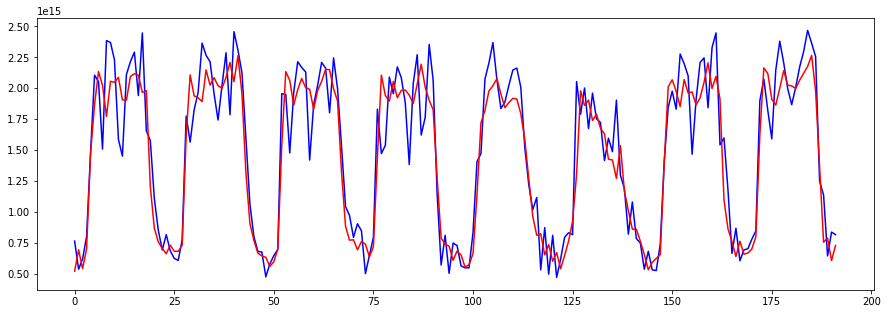

In [46]:
import pymc3 as pm
import matplotlib.pyplot as plt

i = np.random.randint(len(p))


def nbinom(mu, alpha):
    return pm.NegativeBinomial.dist(mu, alpha).random()


params_it = p[i]
mu, alpha = params_it[:, 0], 1 / params_it[:, 1]
samples_it = nbinom(mu, alpha)
y_it = y_val[i].reshape(-1)
n = y_val.shape[-2]

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(np.arange(condition_length + prediction_length), y_it, color='b')
plt.plot(np.arange(condition_length + prediction_length), samples_it, color='r')


In [47]:
# model.save('model.h5')

# Predict on held out set

In [48]:
# %time model = tf.keras.models.load_model('model.h5', custom_objects={'nb_nll': nb_nll})

In [49]:
df_test = pd.concat(featurize(d_test.iloc[:, i], i) for i in range(d_test.shape[-1]) if not i == 222)
df_test['sample_weight'] = df_test.scale_factor / df_test.scale_factor.sum()
indices = np.random.choice(df_test.shape[0], size=10, p=df_test.sample_weight)
%time test_examples = make_examples(df_test, indices)

/home/dante/venvs/python36/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


CPU times: user 21 ms, sys: 0 ns, total: 21 ms
Wall time: 26.1 ms


In [50]:
x_test, y_test = make_batch(test_examples)
x_test['z'] = x_test['z'] / x_test['scale_factor']

In [51]:
ll = np.arange(10)
ll[7:] = 0
ll[7]

0

In [52]:
import scipy.stats as ss

def predict(model, x):
    x = {k: v for k, v in x.items()}
    x['z'][:, condition_length:, :] = 0
    for i in range(condition_length, condition_length + prediction_length):
        predictions = model.predict(x)
        mu, r = predictions[:, i, 0], 1 / predictions[:, i, 1]
        z_hat = nbinom(mu, r)
        x['z'][:, i, 0] = z_hat / x['scale_factor'].reshape(-1)
    return x['z'] * x['scale_factor']

In [55]:
%%time
predictions = []
for _ in range(200):
    predictions.append(predict(model, x_test))

CPU times: user 6min 35s, sys: 22.9 s, total: 6min 58s
Wall time: 11min 45s


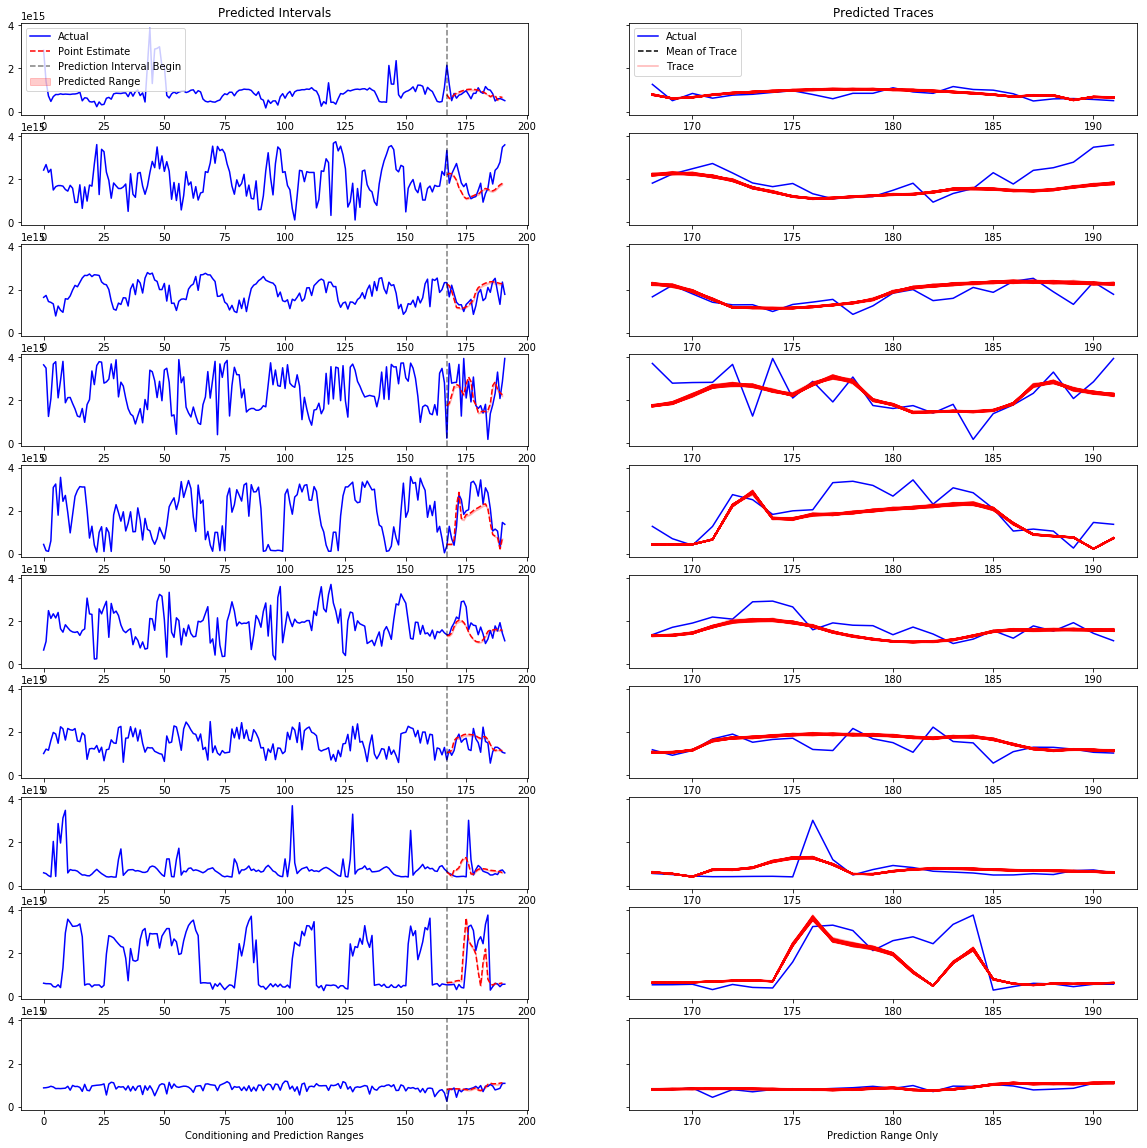

In [56]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(x_test['z']), 2, figsize=(20, 20), sharey=True)
stacked_preds = np.stack(predictions, axis=3)
p_means = np.mean(stacked_preds, axis=(2, 3))
p_mins = np.min(stacked_preds, axis=(2, 3))
p_maxes = np.max(stacked_preds, axis=(2, 3))

axs[0][0].set_title('Predicted Intervals')
axs[0][1].set_title('Predicted Traces')

axs[-1][0].set_xlabel('Conditioning and Prediction Ranges')
axs[-1][1].set_xlabel('Prediction Range Only')

total_length = condition_length + prediction_length

for i, ax in enumerate(axs):
    # plot interval
    ax[0].plot(np.arange(total_length), y_test[i].reshape(-1), color='b', label='Actual')
    ax[0].plot(condition_length + np.arange(prediction_length) - 1, p_means[i][condition_length:], color='r', ls='--', label='Point Estimate')
    ax[0].fill_between(condition_length + np.arange(prediction_length) - 1, p_mins[i, condition_length:], p_means[i, condition_length:], alpha=0.2, color='r', label='Predicted Range')
    ax[0].axvline(condition_length - 1, color='k', ls='--', alpha=0.5, label='Prediction Interval Begin')
    _ = ax[0].legend(loc='upper left') if i == 0 else None

    # plot trace
    x_idx_pred = np.arange(prediction_length) + condition_length
    ax[1].plot(x_idx_pred, y_test[i, condition_length:].reshape(-1), color='b', label='Actual')
    ax[1].plot(x_idx_pred, p_means[i, condition_length:], color='k', ls='--', label='Mean of Trace')
    for j, p_new in enumerate(predictions):
        kwargs = {'label': 'Trace'} if j == 0 else {}
        ax[1].plot(x_idx_pred, p_new[i, condition_length:].reshape(-1), color='r', alpha=0.3, **kwargs)
    _ = ax[1].legend(loc='upper left') if i == 0 else None

plt.savefig('side-by-side.png')